In [9]:
import tensorflow as tf
import numpy as np
import os
from skimage.io import imread,imshow
from skimage.transform import resize
from skimage import color
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split

In [10]:
IMG_HEIGHT = 640
IMG_WIDTH  = 640
CHANNELS = 3


training_images_names = os.listdir('/kaggle/input/unet-dataset/images-20240310T111155Z-001/images/')
training_masks_names = os.listdir('/kaggle/input/unet-dataset/ROI2-20240310T111325Z-001/ROI2/')

X = np.zeros((len(training_images_names),IMG_HEIGHT,IMG_WIDTH,CHANNELS),dtype='uint8')
y = np.zeros((len(training_masks_names),IMG_HEIGHT,IMG_WIDTH,1))

In [11]:
# Find the extra filenames in one of the lists
extra_images = set(training_images_names) - set(training_masks_names)
extra_masks = set(training_masks_names) - set(training_images_names)

print("Extra images:", extra_images)
print("Extra masks:", extra_masks)

# Remove extra mask files from the list of mask filenames
training_masks_names = [mask_name for mask_name in training_masks_names if mask_name not in extra_masks]

print(len(training_masks_names))
y= training_masks_names
# Now, the lengths of training_images_names and training_masks_names should be consistent


Extra images: set()
Extra masks: {'colphocephaly_29b_aug_0_png_jpg.rf.ea0d020ab29fb93a4a3a9c60d6cd46ec.jpg', 'colphocephaly_29b_aug_4_png_jpg.rf.ba7ccb593c6c4596b7171379d716f540.jpg'}
972


In [12]:
images_dir = '/kaggle/input/unet-dataset/images-20240310T111155Z-001/images/'
masks_dir = '/kaggle/input/unet-dataset/ROI2-20240310T111325Z-001/ROI2/'
for i, n in enumerate(training_images_names):
    #print(os.path.join(images_dir, n))
    img = imread(os.path.join(images_dir, n))
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH, CHANNELS), mode='constant', preserve_range=True)
    fn = os.path.splitext(n)[0] + '.jpg'  # Assuming the mask filenames have the same format as image filenames
    #print(os.path.join(masks_dir, fn))
    mask = imread(os.path.join(masks_dir, fn))
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant')
    
    X[i] = img
    y[i] = mask
    
print("Shape of the first image:", X[0].shape)
print("Shape of the first image:", y[0].shape)

Shape of the first image: (640, 640, 3)
Shape of the first image: (640, 640, 1)


149


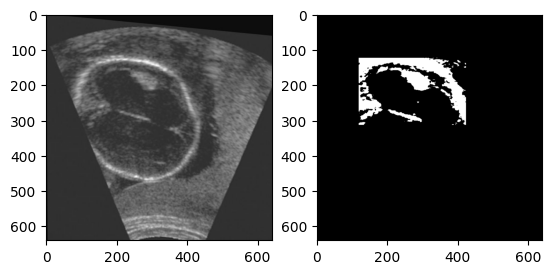

In [13]:
i = np.random.randint(0,len(y))
fig,(a1,a2)=plt.subplots(1,2)
a1.imshow(X[i])
print(i)
a2.imshow(y[i].reshape(y[i].shape[:-1]),cmap='gray')

In [14]:
import tensorflow as tf


IMG_HEIGHT = 640
IMG_WIDTH = 640
CHANNELS = 3
BATCH_SIZE = 32  # Specify your desired batch size here

# Define the input layer with a fixed batch size
new_inputs = tf.keras.layers.Input(batch_shape=(BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, CHANNELS))

s = tf.keras.layers.Lambda(lambda x: x/255)(new_inputs)

# Contracting path
c1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

# Bottleneck
c3 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)

# Expanding path
u2 = tf.keras.layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c3)
u2 = tf.keras.layers.concatenate([u2, c2])
u2 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u2)
u2 = tf.keras.layers.Dropout(0.2)(u2)
u2 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u2)

u1 = tf.keras.layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(u2)
u1 = tf.keras.layers.concatenate([u1, c1])
u1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u1)
u1 = tf.keras.layers.Dropout(0.2)(u1)
u1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u1)

output = tf.keras.layers.Conv2D(1, (1,1), activation='sigmoid')(u1)

# Define the model with the new input layer and output layer
model = tf.keras.Model(inputs=[new_inputs], outputs=[output])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (32, 640, 640, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (32, 640, 640, 3) │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (32, 640, 640,    │        448 │ lambda[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (32, 640, 640,    │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (32, 640, 640,    │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (32, 320, 320,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (32, 320, 320,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (32, 320, 320,    │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (32, 320, 320,    │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (32, 160, 160,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (32, 160, 160,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (32, 160, 160,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (32, 160, 160,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (32, 320, 320,    │      8,224 │ conv2d_5[0][0]    │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (32, 320, 320,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 64)               │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (32, 320, 320,    │     18,464 │ concatenate[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (32, 320, 320,    │          0 │ conv2d_6[0][0]    │
│                     │ 32)               │            │                 

 Total params: 117,041 (457.19 KB)

 Trainable params: 117,041 (457.19 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

In [16]:
# Populate X and y with image and mask data (omitted for brevity)
print(len(X))
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the training and validation sets
print("Training images shape:", len(X_train))
print("Training masks shape:", len(y_train))
print("Validation images shape:", len(X_val))
print("Validation masks shape:", len(y_val))

972
Training images shape: 777
Training masks shape: 777
Validation images shape: 195
Validation masks shape: 195


In [17]:
# Set the verbosity level to ensure epoch information is printed
results = model.fit(X_train, y_train, batch_size=16, epochs=3, verbose=1)


Epoch 1/3
49/49 ━━━━━━━━━━━━━━━━━━━━ 1220s 25s/step - accuracy: 0.9749 - loss: 0.2956
Epoch 2/3
49/49 ━━━━━━━━━━━━━━━━━━━━ 1223s 25s/step - accuracy: 0.9802 - loss: 0.0824
Epoch 3/3
49/49 ━━━━━━━━━━━━━━━━━━━━ 1224s 25s/step - accuracy: 0.9800 - loss: 0.0782


In [18]:
model.save('/kaggle/working/uunet.h5')


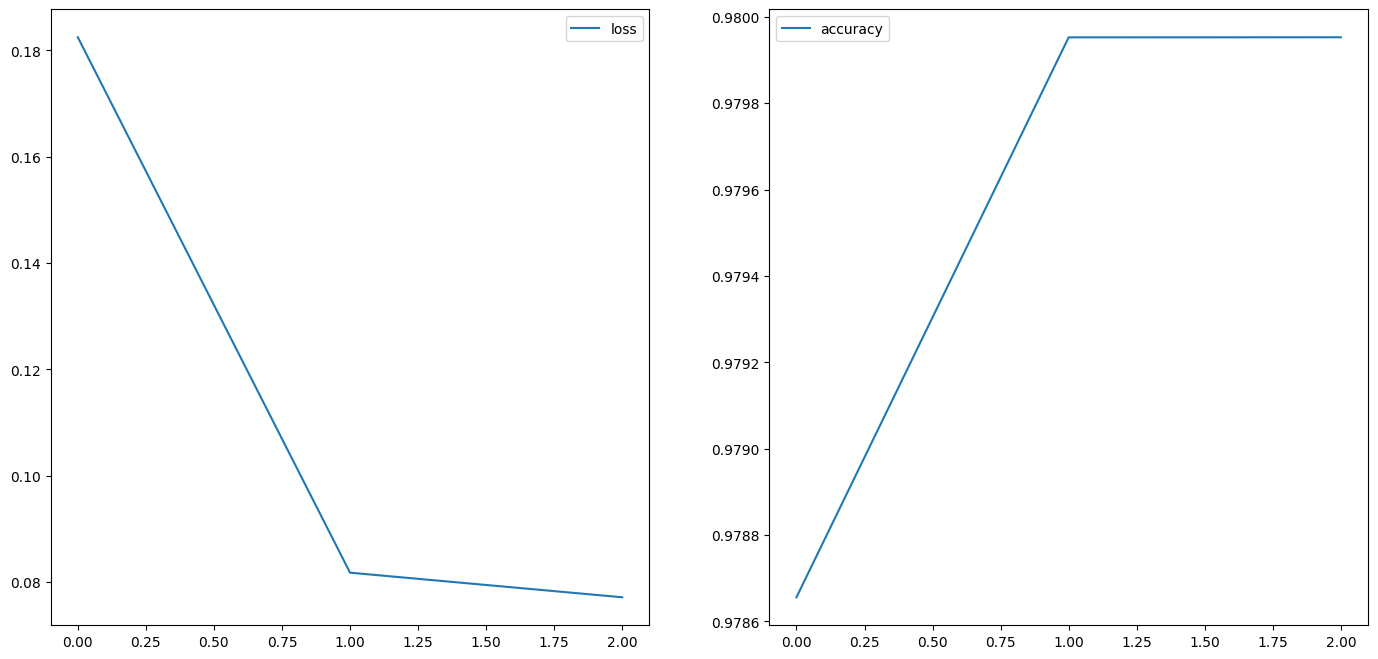

In [19]:
fig, (a1, a2) = plt.subplots(1, 2, figsize=(17, 8))

# Plot loss
a1.plot(np.arange(0, len(results.history['loss'])), results.history['loss'], label='loss')

# Plot accuracy
a2.plot(np.arange(0, len(results.history['accuracy'])), results.history['accuracy'], label='accuracy')

a1.legend()
a2.legend()

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
Total pixels in the predicted mask: 409600
Number of non-zero pixels in the predicted mask: 226147
Number of zero pixels in the predicted mask: 183453


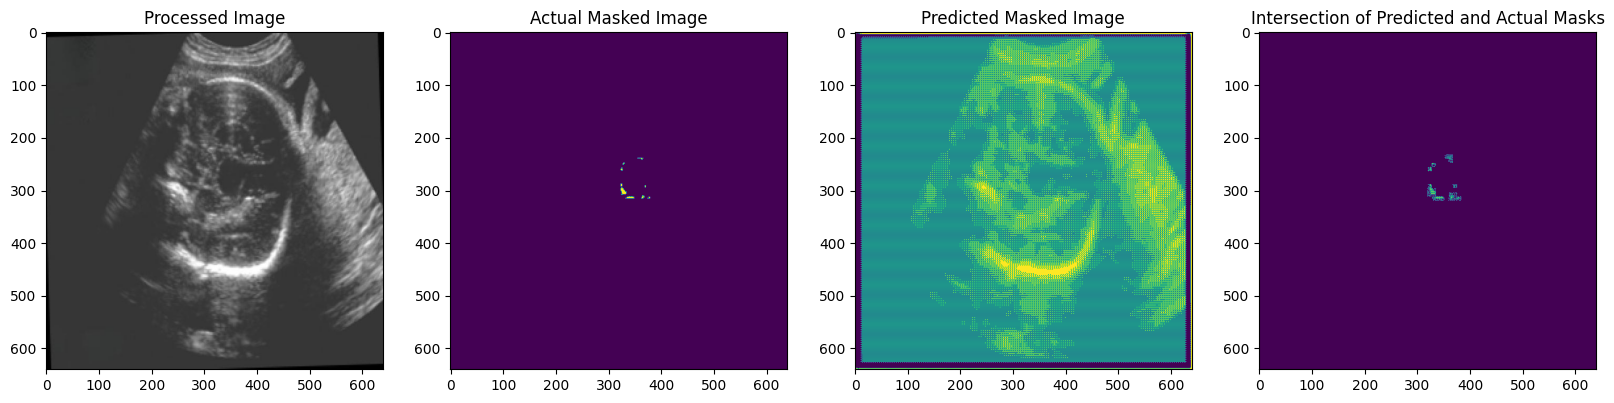

In [90]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Assuming the model variable is defined earlier

def VisualizeResults(index):
    img = X_val[index]
    # Reshape and preprocess the input image
    img = np.expand_dims(img, axis=0)
    img = tf.image.resize(img, (desired_height, desired_width))  # Resize the image to match the model input size
    img = img / 255.0  # Normalize the pixel values
    pred_y = model.predict(img)

    # Apply thresholding
    threshold = 0.00014  # Adjust this value as needed
    pred_mask = (pred_y > threshold).astype(np.uint8)
    
    # Plot the images
    fig, arr = plt.subplots(1, 4, figsize=(20, 15))
    arr[0].imshow(X_val[index])
    arr[0].set_title('Processed Image')
    arr[1].imshow(y_val[index,:,:,0])
    arr[1].set_title('Actual Masked Image')
    arr[2].imshow(pred_mask[0,:,:,0])
    arr[2].set_title('Predicted Masked Image')
    
    # Take the end result of the predicted mask with the actual mask
    intersection = np.logical_and(y_val[index,:,:,0], pred_mask[0,:,:,0])
    arr[3].imshow(intersection)
    arr[3].set_title('Intersection of Predicted and Actual Masks')
    
    # Count the number of zero pixels in the predicted mask
    total_pixels = pred_mask.size
    non_zero_pixels = np.count_nonzero(pred_mask)
    zero_pixels = total_pixels - non_zero_pixels
    print(f"Total pixels in the predicted mask: {total_pixels}")
    print(f"Number of non-zero pixels in the predicted mask: {non_zero_pixels}")
    print(f"Number of zero pixels in the predicted mask: {zero_pixels}")

desired_height = 640
desired_width = 640

VisualizeResults(101)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
Total pixels in the predicted mask: 409600
Number of non-zero pixels in the predicted mask: 254981
Number of zero pixels in the predicted mask: 154619


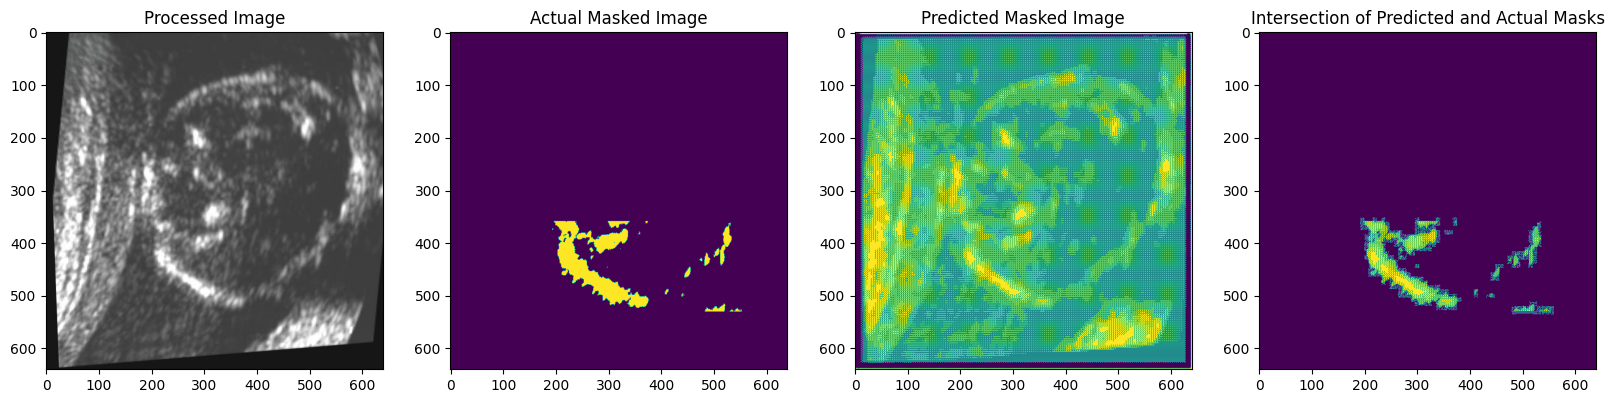

In [94]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def VisualizeResults(model_path, index):
    # Load the model
    model = tf.keras.models.load_model(model_path)

    img = X_val[index]
    # Reshape and preprocess the input image
    img = np.expand_dims(img, axis=0)
    img = tf.image.resize(img, (desired_height, desired_width))  # Resize the image to match the model input size
    img = img / 255.0  # Normalize the pixel values
    pred_y = model.predict(img)

    # Apply thresholding
    threshold = 0.00014  # Adjust this value as needed
    pred_mask = (pred_y > threshold).astype(np.uint8)
    
    # Plot the images
    fig, arr = plt.subplots(1, 4, figsize=(20, 15))
    arr[0].imshow(X_val[index])
    arr[0].set_title('Processed Image')
    arr[1].imshow(y_val[index,:,:,0])
    arr[1].set_title('Actual Masked Image')
    arr[2].imshow(pred_mask[0,:,:,0])
    arr[2].set_title('Predicted Masked Image')
    
    # Take the end result of the predicted mask with the actual mask
    intersection = np.logical_and(y_val[index,:,:,0], pred_mask[0,:,:,0])
    arr[3].imshow(intersection)
    arr[3].set_title('Intersection of Predicted and Actual Masks')
    
    # Count the number of zero pixels in the predicted mask
    total_pixels = pred_mask.size
    non_zero_pixels = np.count_nonzero(pred_mask)
    zero_pixels = total_pixels - non_zero_pixels
    print(f"Total pixels in the predicted mask: {total_pixels}")
    print(f"Number of non-zero pixels in the predicted mask: {non_zero_pixels}")
    print(f"Number of zero pixels in the predicted mask: {zero_pixels}")

desired_height = 640
desired_width = 640
model_path = '/kaggle/working/unet.h5'  # Replace 'path/to/your/model.h5' with the actual path to your model

VisualizeResults(model_path, 100)
